### Package installs
If you are using jupyter lab online, all packages will be available. If you are running this on your local computer, you may need to install some packages. Run the cell below if using jupyter lab locally. 

In [4]:
!pip install numpy
!pip install scipy
!pip install pandas
!pip install scikit-learn
!pip install seaborn

### Importing data
To begin, we need to understand the data.
The ribosome genes are available in a .fasta file called 'ribosome_genes.fasta'. You can have a look if you like.
These genes will be imported as classes (RibosomeGene). 

Each RibosomeGene object has a name, accession, sequence and length.
You can access these properties using '.' syntax. (see below). 

Try to think of each gene as something physical, rather than code.
In real life, each gene has a .length, its organism has a .name, and it has a .sequence. We can write code in this way too. 

we will import these into **ribosome_genes**, which is a list of our genes.

In [5]:
import warnings
warnings.filterwarnings('ignore')

from utilities import import_16s_sequences
ribosome_genes = import_16s_sequences()

In [6]:
print('{:<20}{:<30}{:<15}{:<10}'.format('gene.accession', 'gene.name', 'gene.length', 'gene.sequence'))
for gene in ribosome_genes:
    print('{:<20}{:<30}{:<15}{:<10}'.format(gene.accession, gene.name[:27], gene.length, gene.sequence[:8] + '...'))

gene.accession      gene.name                     gene.length    gene.sequence
EC_A                Escherichia coli DP101        100            CCUUCGGG...
EC_B                Escherichia coli BEBOP        100            CCUUCGGG...
EC_C                Escherichia coli SAMURAI_CH   100            CCUUCGGG...
EC_D                Escherichia coli SAO          100            CCUUCGGG...
EC_E                Escherichia coli code_GEASS   100            CCUUCGGG...
EC_F                Escherichia coli DEATHNOTE    100            CCUUCGGG...
EC_G                Escherichia coli STEINS_GAT   100            CCUUCGGG...
EF_A                Enterococcus faecalis ATCC    100            CCUUUUUG...
EF_B                Enterococcus faecalis EnGen   100            CCUUUUUG...
EF_C                Enterococcus faecalis ATCC    100            CCUUUUUG...
EF_D                Enterococcus faecalis GAH94   100            CCUUUUUG...
HS_A                Homo sapiens (barack obamas   100            CCCGCCGG.

### SECTION 1: PAIRWISE DISTANCES
To be able to compare organisms via their sequences, we need a way to measure their difference as a distance. 

**K-mer distance**<br>
The kmer distance between two sequences is defined here as the total number of k-mers that are unique to either sequence.<br>
eg: If seq1 has 3 unique kmers not found in seq2 (copy number difference also matters), and seq2 has 2 unique kmers, the kmer distance is 5.  

In [7]:
def create_kmer_dictionary(seq, k):
    kmer_dict = {}
    num = len(seq) - k + 1
    for i in range(num):
        kmer = seq[i:i+k]
        if kmer not in kmer_dict:
            kmer_dict[kmer] = 0
        kmer_dict[kmer] += 1
    return kmer_dict

In [8]:
create_kmer_dictionary('CCUUCGGG', 2)

{'CC': 1, 'CU': 1, 'UU': 1, 'UC': 1, 'CG': 1, 'GG': 2}

In [9]:
def calculate_total_unique_kmers(kmers1, kmers2):
    unique_kmers = 0
    c1 = c2 = c3 = c4 = c5 = 0
    for k in kmers1:
        if k not in kmers2:
            c1 += kmers1[k]
        elif k in kmers1 and k in kmers2:
            c2 = c2+ abs(kmers1[k] - kmers2[k])
            
    for k2 in kmers2:
        if k2 not in kmers1:
            c3 += kmers2[k2]
    unique_kmers = c1+c2+c3
            
    return unique_kmers

In [10]:
kmers1 = {'CCUUCGGG':1}
kmers2 = {'CCUUUUUG':2}
calculate_total_unique_kmers(kmers1, kmers2)

3

In [11]:
def kmer_distance(seq1, seq2, k): 
    kmers1 = create_kmer_dictionary(seq1,k)
    kmers2 = create_kmer_dictionary(seq2,k)
    distance = calculate_total_unique_kmers(kmers1, kmers2)
    return distance

Let's check our function. We can use the first two entries in the 'ribosome_genes' list.
If implemented correctly, the following should return 24

In [12]:
distance = kmer_distance(ribosome_genes[1].sequence, ribosome_genes[3].sequence, 8)
print(distance)

24


**smith-waterman alignment**<br>
Another way to compare the similarity of two sequences is through alignment.
The alignment score of two sequences will be high when they are similar, and low when they are distinct. 

Keep in mind the matrix must be 1 element larger than the sequence lengths. Consider whether indel scores for the first row and column need to be filled in.

In [15]:


import numpy as np
def init_scoregrid(seq1, seq2, indel_score=-4):
    rs = len(seq1) +1
    cs = len(seq2) +1
    scoregrid = np.zeros((rs, cs), np.int)
    return scoregrid

Let's do a sanity check that the grid has been initialised properly. <br>
The following should print the initialised scoregrid

In [16]:
print(init_scoregrid('hello', 'kittycat'))

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


Write a function that calculates the initialised scoregrid. It accepts two sequences, a scoregrid and match/mismatch and indel scores. 

In [18]:

import itertools
def calculate_scoregrid(seq1, seq2, scoregrid, match_score=1, mismatch_score=-4, indel_score=-4):
    for i, j in itertools.product(range(1, scoregrid.shape[0]), range(1, scoregrid.shape[1])):
        match = scoregrid[i - 1, j - 1] + (match_score if seq1[i - 1] == seq2[j - 1] else + mismatch_score)
        delete = scoregrid[i - 1, j] + indel_score
        insert = scoregrid[i, j - 1] + indel_score
        scoregrid[i, j] = max(match, delete, insert, 0)

    return scoregrid

Let's do another sanity check. <br>
The following should print a calculated scoregrid, with the these numbers in the bottom right corner: <br>
2  0 <br>
0  3

In [19]:
scoregrid = init_scoregrid('hello', 'helllo')
print(calculate_scoregrid('hello', 'helllo', scoregrid))

[[0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 2 0 0 0 0]
 [0 0 0 3 1 1 0]
 [0 0 0 1 4 2 0]
 [0 0 0 0 0 0 3]]


In [21]:
def report_alignment_score(scoregrid):
    # given a completed scoregrid, return the smith-waterman alignment score.
    sw_alignment_score = scoregrid.max()
    return sw_alignment_score

Final sanity check. Should return 4.

In [22]:
scoregrid = init_scoregrid('hello', 'helllo')
calculated_scoregrid = calculate_scoregrid('hello', 'helllo', scoregrid)
print(report_alignment_score(calculated_scoregrid))

4


Ok! now we're ready to put it all together. <br>
Fill in the function below with the three functions you wrote to calculate the alignment score of two sequences

In [24]:
def smith_waterman(seq1, seq2):
    matrix = init_scoregrid(seq1, seq2, indel_score=-4)
    element_scores = calculate_scoregrid(seq1, seq2, scoregrid, match_score=1, mismatch_score=-4, indel_score=-4)
    alignment_score = report_alignment_score(scoregrid)
    return alignment_score

The following should print 4

In [25]:
print(smith_waterman('hello', 'helllo'))

4


**pairwise distances**

We have now written two functions which can calculate the distance of two sequences. 
We can calculate the k-mer distance, and the smith-waterman alignment score. 
lets use these two methods to calculate the pairwise distance of our genes. 

In [30]:
import numpy as np
def init_distance_matrix(genes):
    values=[]
    for gene in genes:
        s=gene.accession
        values.append(s)
        values.append(0)
    
    distance_matrix = {}
    for gene in ribosome_genes:
        key = gene.accession        
        distance_matrix[key]={values[i]: values[i + 1] for i in range(0, len(values), 2)} 
    return distance_matrix

Let's print the distance matrix to make sure it worked. 

In [31]:
from utilities import print_distance_matrix
distance_matrix = init_distance_matrix(ribosome_genes)
print_distance_matrix(distance_matrix)

        EC_A  EC_B  EC_C  EC_D  EC_E  EC_F  EC_G  EF_A  EF_B  EF_C  EF_D  HS_A  MI_A  SD_A  SF_A  SS_A  SS_B
EC_A     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
EC_B     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
EC_C     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
EC_D     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
EC_E     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
EC_F     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
EC_G     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
EF_A     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
EF_B     0.0   0.0 

Time to fill in the matrix with distances. <br>
Write a function which calculates the pairwise distance of genes using kmer distance.
you will need to call the 'kmer_distance' function you have written above. 

In [32]:
def calculate_kmer_distance_matrix(genes, matrix, k):
    for gene1 in genes:
        key1=gene1.accession
        for gene2 in genes:
            key2=gene2.accession
            matrix[key1][key2]=kmer_distance(gene1.sequence,gene2.sequence,k)

    return matrix

Let's do the same as above, but this time use the 'smith_waterman' alignment distance function you wrote. 

In [34]:
def calculate_sw_alignment_distance_matrix(genes, matrix): 
    for gene1 in genes:
        key1=gene1.accession
        for gene2 in genes:
            key2=gene2.accession
            matrix[key1][key2]=smith_waterman(gene1.sequence,gene2.sequence)
    return matrix
    

Let's test them out. The two cells below will use your calculate_kmer_distance_matrix, and calculate_sw_alignment_distance_matrix functions to add distances to the matrix. <br>
**NOTE:** the smith-waterman distance calculations can take time. Give it a minute.

In [35]:
distance_matrix = init_distance_matrix(ribosome_genes)
kmer_distance_matrix = calculate_kmer_distance_matrix(ribosome_genes, distance_matrix, 8)
print('\nkmer distance matrix')
print_distance_matrix(kmer_distance_matrix)


kmer distance matrix
        EC_A  EC_B  EC_C  EC_D  EC_E  EC_F  EC_G  EF_A  EF_B  EF_C  EF_D  HS_A  MI_A  SD_A  SF_A  SS_A  SS_B
EC_A     0.0  86.0  98.0  94.0  96.0  90.0  96.0 186.0 186.0 186.0 186.0 186.0  96.0  98.0 160.0 106.0 110.0
EC_B    86.0   0.0  32.0  24.0  26.0  24.0  24.0 176.0 182.0 176.0 176.0 186.0  24.0  32.0  92.0  74.0 102.0
EC_C    98.0  32.0   0.0  52.0  40.0  36.0  40.0 186.0 186.0 186.0 186.0 186.0  40.0  32.0  98.0  72.0  96.0
EC_D    94.0  24.0  52.0   0.0  32.0  36.0  32.0 176.0 182.0 176.0 176.0 186.0  36.0  50.0 116.0  82.0 100.0
EC_E    96.0  26.0  40.0  32.0   0.0  26.0  22.0 182.0 186.0 182.0 182.0 186.0  26.0  38.0 116.0  82.0 100.0
EC_F    90.0  24.0  36.0  36.0  26.0   0.0  24.0 186.0 186.0 186.0 186.0 186.0  30.0  28.0 110.0  82.0 100.0
EC_G    96.0  24.0  40.0  32.0  22.0  24.0   0.0 180.0 186.0 180.0 180.0 186.0   8.0  38.0 116.0  82.0 100.0
EF_A   186.0 176.0 186.0 176.0 182.0 186.0 180.0   0.0  44.0  28.0  28.0 186.0 180.0 186.0 182.0 186.0 186

In [36]:
distance_matrix = init_distance_matrix(ribosome_genes)
sw_alignment_distance_matrix = calculate_sw_alignment_distance_matrix(ribosome_genes, distance_matrix)
print('\nsmith waterman alignment score distance matrix')
print_distance_matrix(sw_alignment_distance_matrix)


smith waterman alignment score distance matrix
        EC_A  EC_B  EC_C  EC_D  EC_E  EC_F  EC_G  EF_A  EF_B  EF_C  EF_D  HS_A  MI_A  SD_A  SF_A  SS_A  SS_B
EC_A     5.0   5.0   5.0   5.0   5.0   5.0   5.0   4.0   4.0   4.0   4.0   2.0   5.0   5.0   5.0   5.0   4.0
EC_B     5.0   5.0   5.0   5.0   5.0   5.0   5.0   4.0   4.0   4.0   4.0   2.0   5.0   5.0   5.0   5.0   4.0
EC_C     5.0   5.0   5.0   5.0   5.0   5.0   5.0   4.0   4.0   4.0   4.0   2.0   5.0   5.0   5.0   5.0   4.0
EC_D     5.0   5.0   5.0   5.0   5.0   5.0   5.0   4.0   4.0   4.0   4.0   2.0   5.0   5.0   5.0   5.0   4.0
EC_E     5.0   5.0   5.0   5.0   5.0   5.0   5.0   4.0   4.0   4.0   4.0   2.0   5.0   5.0   5.0   5.0   4.0
EC_F     5.0   5.0   5.0   5.0   5.0   5.0   5.0   4.0   4.0   4.0   4.0   2.0   5.0   5.0   5.0   5.0   4.0
EC_G     5.0   5.0   5.0   5.0   5.0   5.0   5.0   4.0   4.0   4.0   4.0   2.0   5.0   5.0   5.0   5.0   4.0
EF_A     4.0   4.0   4.0   4.0   4.0   4.0   4.0   5.0   5.0   5.0   5.0   2.0  

Let's visualise those in a better manner for human eyes. The cell below will plot heatmaps instead of raw numbers.

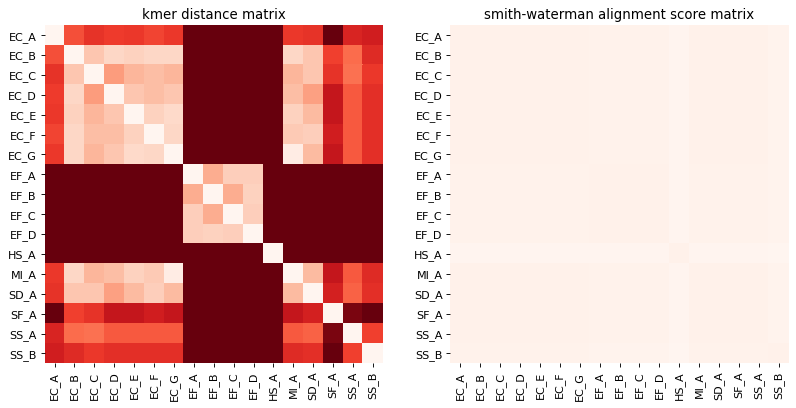

In [37]:
from utilities import heatmap
heatmap(kmer_distance_matrix, sw_alignment_distance_matrix)

### SECTION 2: CLUSTERING

From the heatmaps, it seems like there are a few clusters in the data. <br>
First, lets convert the pairwise distances to 2D coordinates. 
This is possible using Multidimensional scaling (MDS).
After we have transformed the distance matrix to 2D coordinates, we can plot it to see if any clusters are evident.

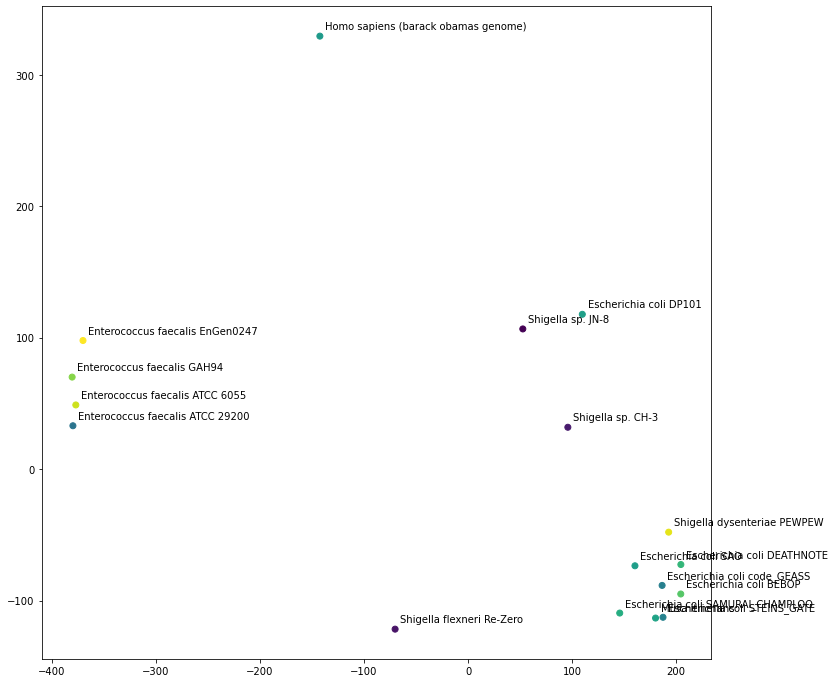

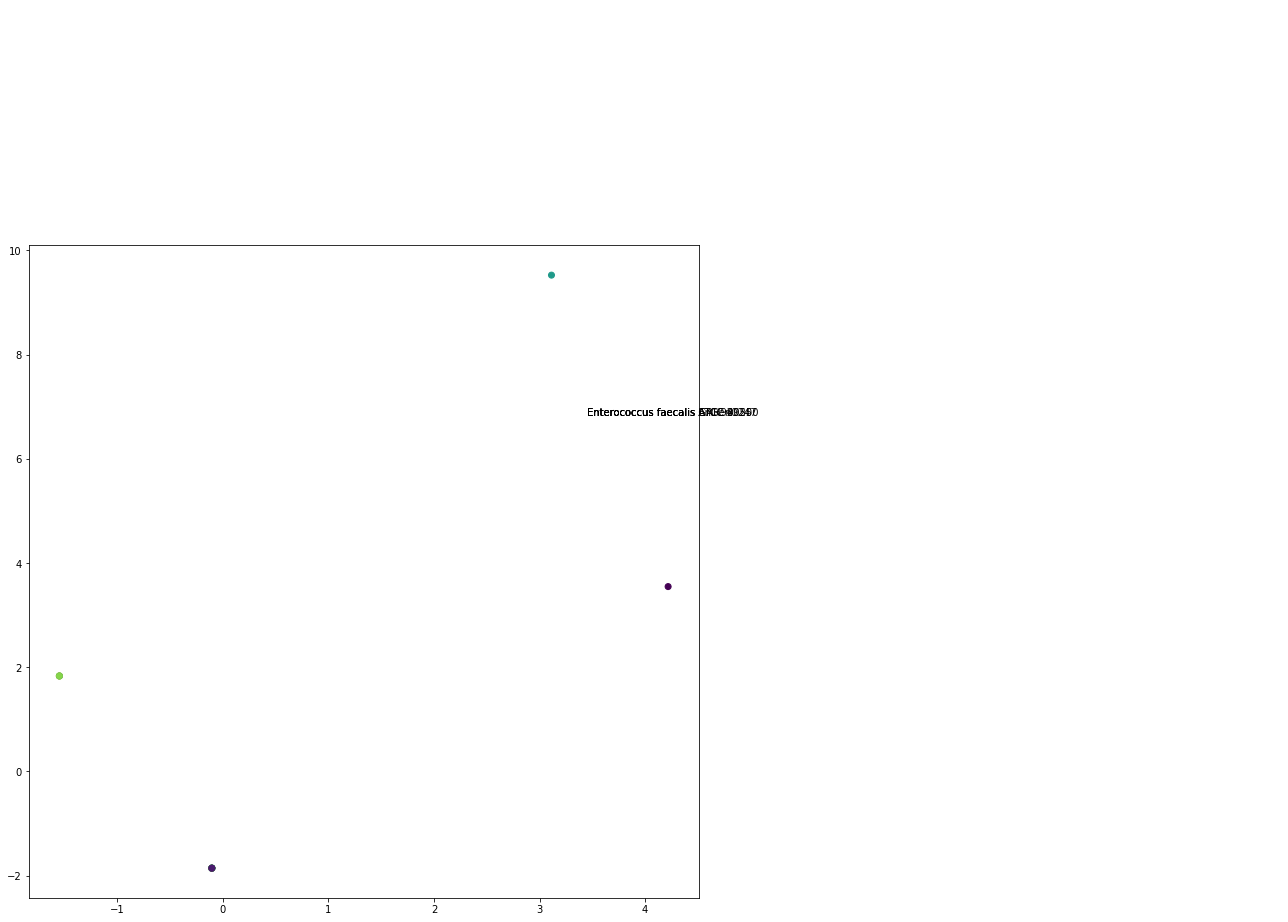

In [38]:
from utilities import mds_scatterplot, distance_matrix_to_coordinates_MDS
kmer_distances_xy = distance_matrix_to_coordinates_MDS(kmer_distance_matrix)
sw_distances_xy = distance_matrix_to_coordinates_MDS(sw_alignment_distance_matrix)
mds_scatterplot(kmer_distances_xy)
mds_scatterplot(sw_distances_xy)

Seems like there is some clustering happening. <br>
Let's use some clustering algorithms to define the clusters. 
in this manner, we can have an objective way to talk about the patterns in the data.

Let's implement the k-means algorithm.

In [39]:
from utilities import initialise_centroids, average_point, assign_points, plot_kmeans, points_equal, euclidean_distance

In [40]:
def calculate_mean_centroids(data, assignments, k):
    centroids = []
    for cluster in range(k):
        points = [point for point, assignment in zip(data, assignments) if assignment == cluster]
        centroids.append(average_point(points))
    return centroids

Place calculate_mean_centroids() in the kmeans function below to complete kmeans

In [41]:
def kmeans(data, k):
    centroids=initialise_centroids(data,k)    
    cluster_assignments=assign_points(centroids,data)
    centroids=calculate_mean_centroids(data,cluster_assignments,k)
    return centroids, cluster_assignments

You can check your implementation using the cell below:

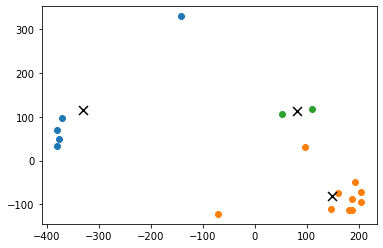

In [42]:
centroids, cluster_assignments = kmeans(kmer_distances_xy, 3)
plot_kmeans(kmer_distances_xy, centroids, cluster_assignments, 3)

Let's also implement k-medoids while we're at it. <br>
The only difference between k-means and k-medoids is the calculate_mean_centroids() step, which will instead be calculate_median_centroids()
the median can be taken here as the point in the cluster which has smallest cumulative distance to the other points in the cluster
You can use the provided euclidean_distance() function to calculate distances between points
write a function which calculates new centroid locations (using the median)

In [46]:
def calculate_median_centroids(data, assignments, k):
    centroids = []
    for cluster in range(k):
        points = [point for point, assignment in zip(data, assignments) if assignment == cluster]
        centroids.append(tuple(np.median(np.array(points), axis=0)))
    return centroids

Place calculate_median_centroids() in the kmedoids function below to complete kmedoids

In [47]:
def kmedoids(data, k):
    centroids=initialise_centroids(data,k)    
    cluster_assignments=assign_points(centroids,data)
    centroids=calculate_median_centroids(data,cluster_assignments,k)
    return centroids, cluster_assignments

Here is another check cell, for kmedoids this time:

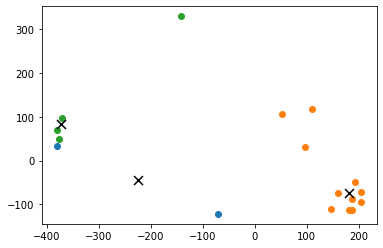

In [48]:
centroids,cluster_assignments = kmedoids(kmer_distances_xy, 3)
plot_kmeans(kmer_distances_xy, centroids, cluster_assignments, 3)